In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import warnings

from ast import literal_eval
from PyPDF2 import PdfMerger
from sklearn.cluster import DBSCAN

from src.data.fetch_information import (
    get_processed_netflix_data,
    get_general_sorted_data,
)
from src.visualization.utils import (
    get_pivoted_data,
    clean_text,
    create_calendar_pivot_table,
)
def initialize_configuration():
    """
    This function establishes the initial configuration:
     - Ignore warnings
     - Use the bmh matplotlib style
     - Use the Reds colormap

    Returns
    -------
    colormap: matplotlib.colors.LinearSegmentedColormap
        The desired colormap resampled (given a number from 0 to 1 a color of
         the colormap will return a corresponding value mapped into 100
         different tones).

    """
    warnings.filterwarnings("ignore")
    colormap = mpl.colors.LinearSegmentedColormap.from_list(
        "", ['red', 'black']
    ).resampled(100)
    return colormap

def get_stacked_profile_duration(netflix_data, image_path='./', cmap=None):
    """

    Parameters
    ----------
    netflix_data

    Returns
    -------

    """
    pivoted_data = get_pivoted_data(netflix_data)
    pivoted_data_filtered = pivoted_data[
        [col for col in pivoted_data.columns if
         not col.startswith('_') and 'total' not in col]
    ]
    pivoted_data_filtered.reset_index(inplace=True)
    pivoted_data_filtered.set_index('start_time', inplace=True)

    pivoted_data_filtered.plot.area(
        stacked=True,
        linewidth=0.1,
        figsize=(13, 8),
        cmap=cmap,
        legend=True
    )
    plt.ylabel('Duración (horas)')
    plt.xlabel('Fecha')
    title_str = 'Duración de tiempo visto en Netflix para cada perfil'
    plt.title(title_str)
    plt.legend(bbox_to_anchor=(1.15, 0.5), loc="center right")
    plt.grid(linestyle='--')
    plt.savefig(
        f'{image_path}img0_netflix_duracion_fecha_perfil.pdf',
        bbox_inches='tight'
    )
    plt.close()


def get_stacked_profile_proportion(netflix_data, image_path='./',cmap=None):
    pivoted_data = get_pivoted_data(netflix_data)
    pivoted_data_filtered = pivoted_data[
        [col for col in pivoted_data.columns if
         col.startswith('_') and '_t' not in col]
    ]
    columns_rename = {col: col[1:] for col in pivoted_data_filtered.columns}
    pivoted_data_filtered.rename(
        columns=columns_rename,
        inplace=True,
    )
    pivoted_data_filtered.reset_index(inplace=True)
    pivoted_data_filtered.set_index('start_time', inplace=True)
    pivoted_data_filtered.plot.area(
        stacked=True,
        linewidth=0.1,
        figsize=(13, 8),
        cmap=cmap,
        legend=True
    )
    plt.ylabel('Proporción')
    plt.xlabel('Fecha')
    plt.ylim(0, 1)
    title_str = 'Proporción de tiempo en netflix para cada perfil.'
    plt.title(title_str)
    plt.legend(bbox_to_anchor=(1.15, 0.5), loc="center right")
    plt.savefig(
        f'{image_path}img1_netflix_proporcion_fecha_perfil.pdf',
        bbox_inches='tight'
    )
    plt.close()

def plot_series_time(series_data_row, image_path='./', cmap=None):
    start_times = pd.to_datetime(literal_eval(series_data_row.all_start_times))
    hour = literal_eval(series_data_row.all_start_time_hours)
    now_time_difference = pd.Series(start_times - datetime.datetime.now()).apply(lambda x: x.days).to_numpy()
    clustering = DBSCAN(min_samples=1, eps=48).fit_predict(now_time_difference.reshape(-1, 1))
    series_title = series_data_row.new_title
    # Create figure and plot
    fig = plt.figure(figsize=(8,5))
    ax = plt.gca()
    plt.scatter(start_times, hour, c=clustering, cmap=cmap)
    plt.plot(start_times, hour, linestyle='--', alpha=0.5, color='k')
    plt.ylabel('Hora del día')
    plt.xlabel('Fecha')
    plt.title(series_title)
    plt.yticks([0, 4, 8, 12, 16, 20, 24])
    plt.ylim(-0.5, 24.5)
    plt.grid(linestyle='--')
    ax.patch.set_facecolor('gainsboro')
    clean_title_text = clean_text(series_title)
    plt.savefig(
        f'{image_path}img2_series__{clean_title_text}.pdf',
        bbox_inches='tight'
    )
    plt.close()

def generate_calendarlike_plot(data, image_path='./', cmap=None):
    calendarized = create_calendar_pivot_table(data)
    plt.figure(figsize=(20, 10))
    sns.heatmap(
        calendarized,
        annot=True,
        linewidth=.5,
        cmap=cmap
    )
    plt.title('Horas totales vistas de Netflix cada mes')
    plt.xlabel('Número de mes')
    plt.ylabel('Año')
    plt.savefig(
        f'{image_path}img3_netflix_horas_mes_anio.pdf',
        bbox_inches='tight'
    )
    plt.close()

def generate_report(image_path, report_path):
    """
    This function grabs all the .pdf files that are in the image_path location
    and then merges them into a single .pdf file saved in the following file:
    {report_path}/report.pdf.

    Parameters
    ----------
    image_path: str
        Os path to the image location.
    report_path: str
        Os path to the report file location.
    Returns
    -------
    None
    """
    merger = PdfMerger()
    for pdf_file in os.listdir(image_path):
        if pdf_file.endswith('.pdf'):
            merger.append(f'{image_path}{pdf_file}')

    merger.write(f"{report_path}report.pdf")
    merger.close()

def process():
    """
    Main process function.

    Returns
    -------
    None
    """
    colormap = initialize_configuration()
    general_path = os.path.join(os.getcwd())
    data_path = os.path.join(general_path, 'data')
    interim_data_path = os.path.join(data_path, 'interim')
    interest_data_file = os.path.join(
        interim_data_path,
        'netflix_data.csv'
    )
    interest_series_file = os.path.join(
        interim_data_path,
        'profile_0_series_info.csv'
    )
    report_path = os.path.join(general_path, 'reports/')
    images_data_path = os.path.join(report_path, 'figures/')

    netflix_data = get_processed_netflix_data(interest_data_file)
    series_data = get_general_sorted_data(
        interest_series_file,
        sorted_by='total_duration_hours',
        limit_rows=30
    )
    

    get_stacked_profile_duration(netflix_data, images_data_path, colormap)
    get_stacked_profile_proportion(netflix_data, images_data_path, colormap)
    generate_calendarlike_plot(netflix_data, images_data_path, colormap)
    series_data.sort_values('total_duration_hours', ascending=False)\
        .apply(
            plot_series_time,
            image_path=images_data_path,
            cmap=colormap,
            axis=1,
        )
    generate_report(images_data_path, report_path)

In [ ]:

    colormap = initialize_configuration()
    general_path = os.path.join(os.getcwd(), '..')
    data_path = os.path.join(general_path, 'data')
    interim_data_path = os.path.join(data_path, 'interim')
    interest_data_file = os.path.join(
        interim_data_path,
        'netflix_data.csv'
    )
    interest_series_file = os.path.join(
        interim_data_path,
        'profile_0_series_info.csv'
    )
    
    interest_movies_file = os.path.join(
        interim_data_path,
        'profile_0_movie_info.csv'
    )
    report_path = os.path.join(general_path, 'reports/')
    images_data_path = os.path.join(report_path, 'figures/')

    netflix_data = get_processed_netflix_data(interest_data_file)
    series_data = get_general_sorted_data(
        interest_series_file,
        sorted_by='total_duration_hours',
        limit_rows=30
    )
    movies_data = get_general_sorted_data(
        interest_movies_file,
    )

In [ ]:
series_data.sort_values('total_duration_hours').plot.barh(x='new_title', y='total_duration_hours')

In [ ]:
movies_data.sort_values('total_duration_seen').tail(30).plot.barh(x='new_title', y='total_duration_seen')

In [26]:
# def interest_netflix_data_filtered_intersection(row):
#     time_filter = netflix_data.start_time.between(
#         row.start_time, 
#         row.end_time
#     )
#     title_filter = netflix_data.title != row.title
#     interest_netflix_data = netflix_data[((time_filter) & (title_filter))]
#     return interest_netflix_data


# def amount_of_intersected_series_or_movies(row):
#     interest_netflix_data = interest_netflix_data_filtered_intersection(row)
#     len_intersected_series_or_movies = interest_netflix_data.shape[0]
#     return len_intersected_series_or_movies

# def list_of_intersected_series_or_movies(row):
#     interest_netflix_data = interest_netflix_data_filtered_intersection(row)
#     what_was_watched = interest_netflix_data.title.to_list()
#     return what_was_watched

In [27]:
# netflix_data['amount_of_intersected_series_or_movies'] = netflix_data.apply(
#     amount_of_intersected_series_or_movies, axis=1
# )

In [28]:
# netflix_data['list_of_intersected_series_or_movies'] = netflix_data.apply(
#     list_of_intersected_series_or_movies, axis=1
# )

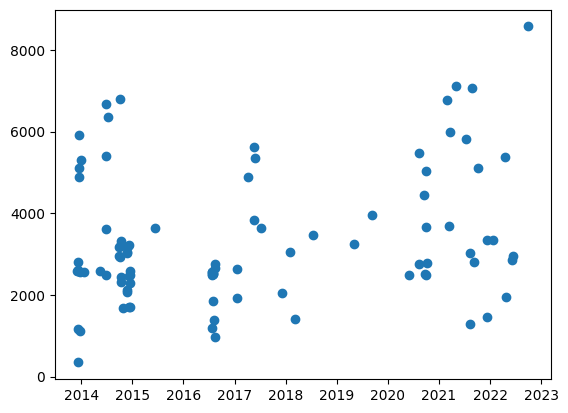

In [30]:
# isom = netflix_data[netflix_data.amount_of_intersected_series_or_movies>1]
# plt.scatter(isom.start_time, isom.duration)

In [135]:
# def duration_seen_last_week_same_profile(row):
#     same_profile = netflix_data.profile_name == row.profile_name
#     below_time = netflix_data.end_time < row.start_time
#     above_time = netflix_data.start_time > row.start_time - datetime.timedelta(days=7)
#     filters = ((same_profile) & (below_time) & (above_time))
#     total_duration = netflix_data[filters].duration.sum()
#     return total_duration

# netflix_data['duration_seen_last_week_same_profile'] = netflix_data.apply(
#     duration_seen_last_week_same_profile, axis=1
# )